# Trajectory Imitation Task
Learn trajectory from human demonstration and transfer it to task space of a robotic arm

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import c3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

sys.path.append("../")
from dmpling.dmp import DMP

## Load sensor data of a person waving the right hand

In [3]:
# read Motion Capture data
reader = c3d.Reader(open('../assets/moc_s01_a06_r01.c3d', 'rb'))
data = reader.read_frames()
data = list(data)

data = [data[i][1][:, 0:3] for i in range(np.int(np.ceil(len(data))))]
data = np.array(data)

# Sample and smooth
data = data[1000:1600]
data = np.concatenate((data, data, data))

data = savgol_filter(data, 401, 3, axis=0)
data = savgol_filter(data, 401, 3, axis=0)
data += 1000

n_frames = data.shape[0]

In [4]:
# indices of links
head = 0
back = np.arange(3, 7)
left_hand = np.arange(11, 19)
right_hand = [19, 20, 21, 22, 24]
left_leg = [27, 28, 30, 31, 32, 33, 34]
right_leg = [35, 37, 38, 39, 40, 41, 42]

In [5]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5),frameon=False)
ax = fig.add_subplot(111, projection='3d')

fig.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
ax.margins(0, 0, 0)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
fig.tight_layout()
ax.view_init(0, -90)

points0 = data[300][:, 0:3]
for frame in np.arange(data.shape[0], step=20):
    ax.cla()
    points = data[frame][:, 0:3]

    ax.scatter(points[head, 0], points[head, 1], points[head, 2], c='orange', s=600)
    ax.plot(points0[left_hand, 0], points0[left_hand, 1], points0[left_hand, 2], c='b', linewidth=10)
    
    ax.plot(points[right_hand, 0], points[right_hand, 1], points[right_hand, 2], c='b', linewidth=10)
    ax.scatter(points[right_hand[-1], 0], points[right_hand[-1], 1], points[right_hand[-1], 2], c='pink')
    ax.plot(data[frame-100:frame, right_hand[-1], 0], data[frame-100:frame, right_hand[-1], 1], data[frame-100:frame, right_hand[-1], 2], 
            c='pink', linewidth=4)
    
    ax.plot(points0[left_leg, 0], points0[left_leg, 1], points0[left_leg, 2], c='y', linewidth=10)
    ax.plot(points0[right_leg, 0], points0[right_leg, 1], points0[right_leg, 2], c='m', linewidth=10)

    ax.axis("off")
    ax.grid(False)
    fig.subplots_adjust(bottom=-0.5)
    ax.set_xlim(np.min(data[:, :, 0]), np.max(data[:, :, 0]))
    ax.set_ylim(np.min(data[:, :, 1]), np.max(data[:, :, 1]))
    ax.set_zlim(np.min(data[:, :, 2]), np.max(data[:, :, 2]))
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 1, 1]))
    
    fig.canvas.draw()
    
%matplotlib inline

<IPython.core.display.Javascript object>

## Learn trajectory from demonstration
Imitate human's right trajectory and scale it such that it can be performed by a robotic arm

In [6]:
# Trajectory of human's hand
traj_x = data[:, right_hand[-1], 0]
traj_y = data[:, right_hand[-1], 1]

# Adjust initial coordinates
traj_x = traj_x - traj_x[0]
traj_y = traj_y - traj_y[0]

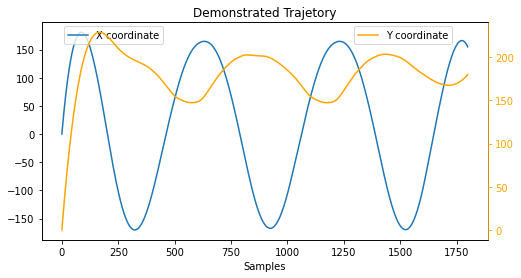

In [22]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(traj_x.shape[0]), traj_x, label="X coordinate")
ax2 = ax.twinx()
ax2.spines["right"].set_edgecolor("orange")
ax2.tick_params(axis='y', colors="orange")
ax2.plot(range(traj_y.shape[0]), traj_y, label="Y coordinate", c="orange")

ax.legend(loc=(0.05, 0.9))
ax2.legend(loc=(0.7, 0.9))
ax.set_xlabel("Samples")
plt.title("Demonstrated Trajetory")
plt.show()

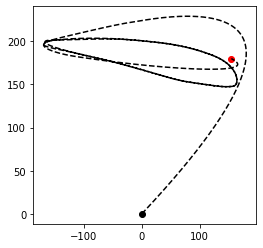

In [23]:
plt.figure(figsize=(4, 4))
plt.scatter([traj_x[0]], [traj_y[0]], c="k")
plt.scatter([traj_x[-1]], [traj_y[-1]], c="r")
plt.plot(traj_x, traj_y, c="k", linestyle="--")
plt.show()

In [9]:
# define DMPs
dt = 1e-3
T = n_frames * dt
a = 10
b = a / 4
n_bfs = 100

# DMP for X coordinate
dmp_x = DMP(T, dt, n_bfs=n_bfs, a=a, b=b)
dmp_x.fit(traj_x)
learned_x = np.zeros(dmp_x.cs.N)
for i in range(dmp_x.cs.N):
    learned_x[i], _, _, _ = dmp_x.step(k=1.0, goal=10)
    
    
# DMP for Y coordinate
dmp_y = DMP(T, dt, n_bfs=n_bfs, a=a, b=b)
dmp_y.fit(traj_y - traj_y[0])
learned_y = np.zeros(dmp_y.cs.N)
for i in range(dmp_y.cs.N):
    learned_y[i], _, _, _ = dmp_y.step(k=1.0, goal=10)

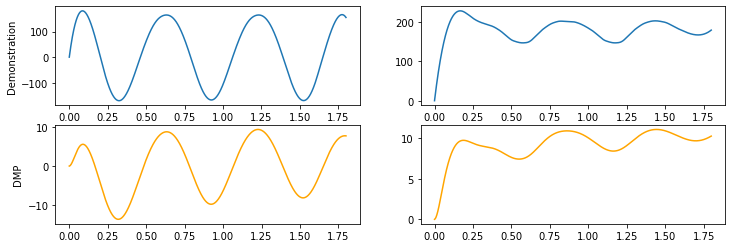

In [25]:
%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize=(12, 4))

ax[0, 0].plot(np.linspace(0, T, n_frames), traj_x)
ax[0, 0].set_ylabel("Demonstration")
ax[0, 1].plot(np.linspace(0, T, n_frames), traj_y)

ax[1, 0].plot(np.arange(0, T, dt), learned_x, c="orange")
ax[1, 0].set_ylabel("DMP")
ax[1, 1].plot(np.arange(0, T, dt), learned_y, c="orange")

fig.show()

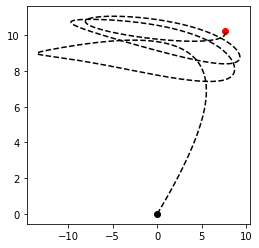

In [26]:
plt.figure(figsize=(4, 4))
plt.scatter([learned_x[0]], [learned_y[0]], c="k")
plt.scatter([learned_x[-1]], [learned_y[-1]], c="r")
plt.plot(learned_x, learned_y, c="k", linestyle="--")
plt.show()

## Animate with simulated planar robotic arm

In [12]:
!git clone https://github.com/tsitsimis/planar-robot.git

Cloning into 'planar-robot'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 93 (delta 12), reused 34 (delta 11), pack-reused 56
Unpacking objects: 100% (93/93), 2.63 MiB | 1.64 MiB/s, done.


In [13]:
sys.path.append("./planar-robot")
from planarobot import utils
from planarobot.planar_arm import PlanarArm

In [18]:
# robot
total_arm_length = 22
n_links = 3
links = (total_arm_length / n_links) * np.ones(n_links)
robot = PlanarArm(links, base_pos=np.array([-10, 0]))

In [19]:
learned_traj = np.stack((learned_x, learned_y)).T
learned_traj_d = utils.calc_derivatives(learned_traj, dt)

robot_pos = robot.trajectory_planning(learned_traj, learned_traj_d, dt, Kp=50)

In [21]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(6, 6))

for i in range(n_frames):
    if np.mod(i, 10) == 0:
        ax.cla()
        ax.axis("off")

        robot.plot(robot_pos[i], ax=ax, arm_width=4, joint_size=40)
        ax.plot(robot_pos[i-100:i, -1, 0], robot_pos[i-100:i, -1, 1], c="k")
            
        ax.set_xlim([-15, 10])
        ax.set_ylim([-10, 15])

        fig.canvas.draw()
        
%matplotlib inline

<IPython.core.display.Javascript object>